In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# Classical ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Tree/Ensemble ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_style("whitegrid")

BASE_DIR = r"D:\ML_Project"
DATA_PATH = os.path.join(BASE_DIR, "data", "processed", "PROJECT_CLUSTERED_SEVERITY_DATA.csv")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

RANDOM_STATE = 42
CV_FOLDS = 5

print("Config loaded.")


Config loaded.


In [2]:
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))

drop_cols = [
    "primaryid","caseid","caseversion","fda_dt_parsed",
    "all_reaction_pts","severity_category","severity_weight",
    "failure_phenotype","is_failure"
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
print(df.shape)

# target
y = df["failure_phenotype_label"].astype(str)
X = df.drop(columns=["failure_phenotype_label"])

# encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
joblib.dump(le, os.path.join(MODELS_DIR, "label_encoder.joblib"))
print("Label encoder saved.")


Rows: 249048
(249048, 21)
Label encoder saved.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)

num_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number)]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.joblib"))
print("Scaler saved.")


Scaler saved.


In [4]:
classical_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (Linear)": SVC(kernel="linear", class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "Naive Bayes": GaussianNB(),
}

ensemble_models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300, class_weight="balanced", n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss"),
    "LightGBM": LGBMClassifier(objective="multiclass", num_class=3),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0),
}


In [5]:
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_models(model_dict):
    scores = {}
    for name, model in model_dict.items():
        try:
            cv_score = cross_val_score(
                model, X_train_scaled, y_train, cv=cv, scoring="f1_macro", n_jobs=-1
            )
            scores[name] = cv_score.mean()
            print(f"{name}: {cv_score.mean():.4f}")
        except Exception as e:
            scores[name] = np.nan
            print(f"{name}: ERROR → {e}")
    return pd.DataFrame.from_dict(scores, orient="index", columns=["f1_macro"])
    
print("\n=== Classical Models (CV) ===")
cv_classical = evaluate_models(classical_models).sort_values("f1_macro", ascending=False)

print("\n=== Ensemble Models (CV) ===")
cv_ensemble = evaluate_models(ensemble_models).sort_values("f1_macro", ascending=False)



=== Classical Models (CV) ===
Logistic Regression: 0.7642
SVM (Linear): 0.7612
KNN: 0.7771
Naive Bayes: 0.6984

=== Ensemble Models (CV) ===
Random Forest: 0.8066
Extra Trees: 0.7991
Gradient Boosting: 0.7642
XGBoost: 0.7819
LightGBM: 0.7751
CatBoost: 0.7850


In [6]:
top2_classical = cv_classical.head(2).index.tolist()
top2_ensemble = cv_ensemble.head(2).index.tolist()

print("\nSelected for Grid Search:")
print("Top Classical:", top2_classical)
print("Top Ensemble:", top2_ensemble)



Selected for Grid Search:
Top Classical: ['KNN', 'Logistic Regression']
Top Ensemble: ['Random Forest', 'Extra Trees']


In [12]:
# ============================================
# GRID SEARCH – 4 SELECTED MODELS
# ============================================

param_grids = {

    "KNN": {
        "n_neighbors": [5, 11, 15, 21],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski", "euclidean"]
    },

    "Logistic Regression": {
        "C": [0.1, 1, 5, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "class_weight": ["balanced"]
    },

    "Random Forest": {
        "n_estimators": [200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced"]
    },

    "Extra Trees": {
        "n_estimators": [200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced"]
    },
}

grid_models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=2000,n_jobs=1),
    "Random Forest": RandomForestClassifier(n_jobs=1),
    "Extra Trees": ExtraTreesClassifier(n_jobs=1)
}

best_grid_models = {}
grid_results = {}


GRID SEARCH (Low Load Mode): KNN
Best Score: 0.7792
Best Params: {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'uniform'}
Cooling down CPU for 10 sec...


GRID SEARCH (Low Load Mode): Logistic Regression
Best Score: 0.7641
Best Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Cooling down CPU for 10 sec...


GRID SEARCH (Low Load Mode): Random Forest
Best Score: 0.8099
Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Cooling down CPU for 10 sec...


GRID SEARCH (Low Load Mode): Extra Trees
Best Score: 0.8005
Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Cooling down CPU for 10 sec...


######################################################################
EVALUATION OF GRID-SEARCH MODELS ON TEST SET
######################################################################

------------------------------------------------------------
E

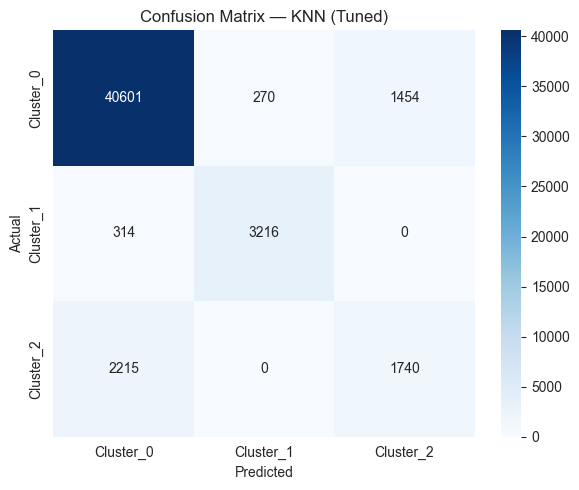

Cooling 5 sec before next model...


------------------------------------------------------------
Evaluating Tuned Model: Logistic Regression
F1-macro: 0.7663
              precision    recall  f1-score   support

   Cluster_0       0.99      0.79      0.88     42325
   Cluster_1       0.91      0.98      0.95      3530
   Cluster_2       0.31      0.96      0.47      3955

    accuracy                           0.82     49810
   macro avg       0.74      0.91      0.77     49810
weighted avg       0.93      0.82      0.85     49810



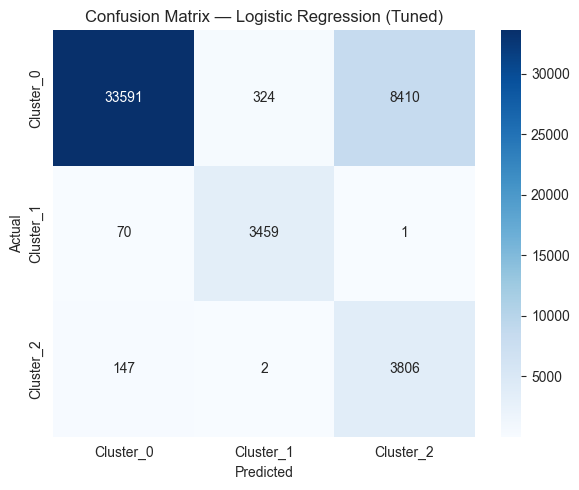

Cooling 5 sec before next model...


------------------------------------------------------------
Evaluating Tuned Model: Random Forest
F1-macro: 0.8101
              precision    recall  f1-score   support

   Cluster_0       0.98      0.87      0.93     42325
   Cluster_1       0.93      0.98      0.95      3530
   Cluster_2       0.40      0.87      0.55      3955

    accuracy                           0.88     49810
   macro avg       0.77      0.91      0.81     49810
weighted avg       0.93      0.88      0.90     49810



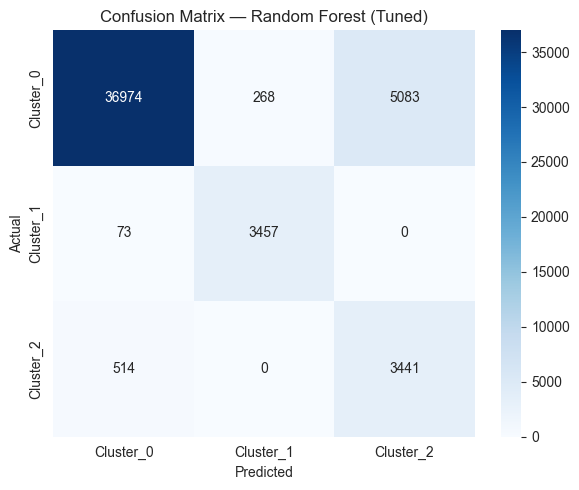

Cooling 5 sec before next model...


------------------------------------------------------------
Evaluating Tuned Model: Extra Trees
F1-macro: 0.8011
              precision    recall  f1-score   support

   Cluster_0       0.98      0.87      0.92     42325
   Cluster_1       0.91      0.96      0.93      3530
   Cluster_2       0.40      0.84      0.54      3955

    accuracy                           0.88     49810
   macro avg       0.76      0.89      0.80     49810
weighted avg       0.93      0.88      0.89     49810



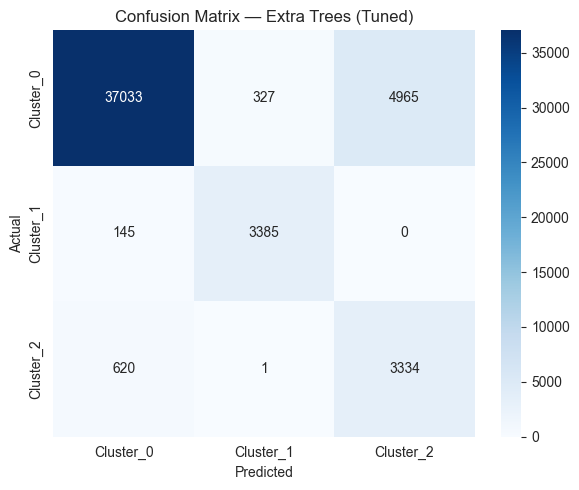

Cooling 5 sec before next model...



In [13]:
import time 
# ============================================
# RUN GRID SEARCH (LOW CPU LOAD MODE)
# ============================================

for name, model in grid_models.items():
    print("\n" + "="*70)
    print(f"GRID SEARCH (Low Load Mode): {name}")

    gs = GridSearchCV(
        model,
        param_grids[name],
        scoring="f1_macro",
        cv=3,
        n_jobs=1,          # <<< IMPORTANT: use 1 core only (low heat)
        verbose=0          # <<< no spam, less CPU
    )

    gs.fit(X_train_scaled, y_train)

    best_grid_models[name] = gs.best_estimator_
    grid_results[name] = gs.best_score_

    print(f"Best Score: {gs.best_score_:.4f}")
    print("Best Params:", gs.best_params_)

    print("Cooling down CPU for 10 sec...\n")
    time.sleep(10)         # <<< COOL-DOWN BREAK between models

# ============================================
# EVALUATION ON TEST SET
# ============================================

print("\n" + "#"*70)
print("EVALUATION OF GRID-SEARCH MODELS ON TEST SET")
print("#"*70)

for name, model in best_grid_models.items():

    print("\n" + "-"*60)
    print(f"Evaluating Tuned Model: {name}")

    # Add a small delay before evaluation
    time.sleep(3)

    y_pred = model.predict(X_test_scaled)

    print(f"F1-macro: {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=le.classes_,
        yticklabels=le.classes_
    )
    plt.title(f"Confusion Matrix — {name} (Tuned)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print("Cooling 5 sec before next model...\n")
    time.sleep(5)